# SQL Agent

In [67]:
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import AzureChatOpenAI

In [68]:
from langchain_community.tools.sql_database.tool import (
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDatabaseTool,
    InfoSQLDatabaseTool
)
from langchain_core.messages.system import SystemMessage
from langchain_community.utilities.sql_database import SQLDatabase

In [69]:
from pydantic import BaseModel
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

In [70]:
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

True

## SQL Tools

In [71]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]  # basically passes the history through

In [72]:
# Initalize database 
db_shop = SQLDatabase.from_uri("sqlite:///shop.db")
db_finance = SQLDatabase.from_uri("sqlite:///finance.db")

In [73]:
db_shop_sql_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)

In [74]:
db_finance_sql_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)

In [75]:
db_shop_list_tool = ListSQLDatabaseTool(db = db_shop)
db_shop_info_tool = InfoSQLDatabaseTool(db=db_shop)
db_shop_query_checker_tool = QuerySQLCheckerTool(
    db = db_shop,
    llm = db_shop_sql_llm)
db_shop_query_tool = QuerySQLDatabaseTool(db = db_shop)

db_shop_list_tool.name = 'sql_db_shop_list_tables'
db_shop_info_tool.name = 'sql_db_shop_schema'
db_shop_query_checker_tool.name = 'sql_db_shop_query_checker'
db_shop_query_tool.name = 'sql_db_shop_query'


In [76]:
db_finance_list_tool = ListSQLDatabaseTool(db = db_finance)
db_finance_info_tool = InfoSQLDatabaseTool(db=db_finance)
db_finance_query_checker_tool = QuerySQLCheckerTool(
    db = db_finance,
    llm = db_finance_sql_llm )
db_finance_query_tool = QuerySQLDatabaseTool(db = db_finance)

db_finance_list_tool.name = 'sql_db_finance_list_tables'
db_finance_info_tool.name = 'sql_db_finance_schema'
db_finance_query_checker_tool.name = 'sql_db_finance_query_checker'
db_finance_query_tool.name = 'sql_db_finance_query'

In [77]:
class HumanFeedback(BaseModel):
    """Ask the human a question"""
    name: str = 'AskHuman'
    description:str = 'Get users feed back to check for final approval of the output'
    question: str

In [78]:
db_tools = [
    db_finance_list_tool,
    db_finance_info_tool,
    db_finance_query_checker_tool,
    db_finance_query_tool,
    db_shop_list_tool,
    db_shop_info_tool,
    db_shop_query_checker_tool,
    db_shop_query_tool,
]

In [79]:
all_tools = db_tools + [AskHuman]

## agent

In [91]:
agent_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)
agent_llm = agent_llm.bind_tools(all_tools)

# System message
sys_msg = SystemMessage(content="""You are a data mapping assistant profficient with SQL whose job is to use the 2 databases shop and finance that you are connected to, to match fields with the list of fields in a dataset.
There are 4 main tasks:
1. Match fields, find all possible matches from both data bases and give a confidence rating of low medium high based on how confident you are that that database table field maps to the given field.
2. Always ask the user for feedback after being done with the mapping using the feedback tool.
3. Generate the SQL query to give you the final data table
4. Ensure that if columns are joint from different databases/tables match the same field, convert them same format for example, categories of countries might be (US, EU...) in one but in another it is (America, Europe ...) and numerical value are in the same precision/units.
""")
   
def chatbot(state: State):
    return {"messages": [agent_llm.invoke([sys_msg] + state["messages"])]}

In [92]:
import json
from langchain_core.messages import ToolMessage
class DBToolsNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [93]:
def ask_human(state):
    if messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError("No message found in input")
    
    print(message)

    feedback = interrupt("Is there any feedback:")
    for tool_call in message.tool_calls:
        user_message = [
            {
                'content': feedback,
                'name': 'ask_human',
                'role': 'user',
                "type": "tool",
                'tool_call_id': tool_call["id"]
            }
        ]
    return {"messages": user_message}

In [94]:
db_tools_node = DBToolsNode(tools = db_tools)

In [95]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        if ai_message.tool_calls[0]["name"] == "AskHuman":
            return "ask_human"
        return "db_tools"
    return END

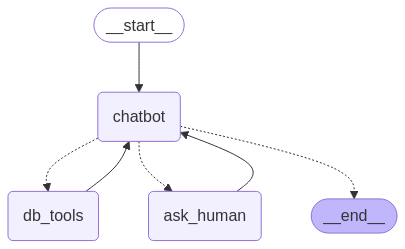

In [96]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("db_tools", db_tools_node)
graph_builder.add_node("ask_human", ask_human)
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools
)
graph_builder.add_edge("ask_human", "chatbot")
graph_builder.add_edge("db_tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [97]:
config = {"configurable": {"thread_id": "2"}}
for event in graph.stream(
    {
        "messages": [
            {
                "role": "user", 
                "content": "table field: user id, email, most bought product, most common payment method"}
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()
    pass

================================ Human Message =================================

table field: user id, email, most bought product, most common payment method
================================== Ai Message ==================================
Tool Calls:
  sql_db_shop_list_tables (call_5E3tvXL4zevxGpCutIxjBBri)
 Call ID: call_5E3tvXL4zevxGpCutIxjBBri
  Args:
  sql_db_finance_list_tables (call_FsUP7hhLp9fI9dnbJk70eiL9)
 Call ID: call_FsUP7hhLp9fI9dnbJk70eiL9
  Args:
================================= Tool Message =================================
Name: sql_db_finance_list_tables

"cost_prices, financial_payments"
================================== Ai Message ==================================
Tool Calls:
  sql_db_shop_schema (call_cQgXG7fU9iJ8s0otbQNPhUqS)
 Call ID: call_cQgXG7fU9iJ8s0otbQNPhUqS
  Args:
    table_names: users, orders, order_items, products
  sql_db_finance_schema (call_AINCc8pAy5rvD5xeuy6uqA1W)
 Call ID: call_AINCc8pAy5rvD5xeuy6uqA1W
  Args:
    table_names: financial_payme

In [98]:
graph.get_state(config).next

()

In [99]:
for event in graph.stream(Command(resume="it is good"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here are the potential matches for the fields you provided from the `shop` and `finance` databases:

1. **user id**
   - **shop.users.user_id**: High confidence (exact match)
   - **finance.financial_payments.order_id**: Low confidence (not a direct match, but related)

2. **email**
   - **shop.users.email**: High confidence (exact match)

3. **most bought product**
   - **shop.products.product_name**: Medium confidence (could be inferred from order data, but not a direct match)
   - **shop.order_items.product_id**: Medium confidence (could be used to determine the most bought product through aggregation)

4. **most common payment method**
   - **shop.order_items.payment_method**: High confidence (direct match)
   - **finance.financial_payments.payment_method**: High confidence (direct match)

### Summary of Matches:
- **user id**: shop.users.user_id (High)
- **email**: shop.users.email (High)
- **most bo

In [90]:
for event in graph.stream(
    {
        "messages": [
            {
                "role": "user", 
                "content": "give me the list of the tools that you have acccess to"}
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()
    pass

================================ Human Message =================================

give me the list of the tools that you have acccess to
================================== Ai Message ==================================

Here are the tools I have access to:

1. **List Tables**:
   - `functions.sql_db_finance_list_tables`: Retrieve a list of tables from the finance database.
   - `functions.sql_db_shop_list_tables`: Retrieve a list of tables from the shop database.

2. **Get Schema**:
   - `functions.sql_db_finance_schema`: Get the schema and sample rows for specified tables in the finance database.
   - `functions.sql_db_shop_schema`: Get the schema and sample rows for specified tables in the shop database.

3. **Query Checker**:
   - `functions.sql_db_finance_query_checker`: Validate SQL queries for the finance database.
   - `functions.sql_db_shop_query_checker`: Validate SQL queries for the shop database.

4. **Execute Query**:
   - `functions.sql_db_finance_query`: Execute SQL querie